In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import statistics
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
import pickle
%matplotlib inline

In [12]:
# Undistort image

# set number of corners
nx = 9
ny = 6

# define opject points where the points should be in the real world 
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

path = 'camera_cal'
images_list = os.listdir(path)
#images_list = ['calibration2.jpg']

for name_img_cal in images_list: 
    img_cal = mpimg.imread('camera_cal/' + name_img_cal)
    
    # convert to grayscale
    gray = cv2.cvtColor(img_cal, cv2.COLOR_BGR2GRAY)

    # identify chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # if identifaction of corners was succuessful append 
    if ret == True:
        # Draw and display the corners
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # draw corners and save pictures 
        #img_corners = cv2.drawChessboardCorners(img_cal, (nx,ny), corners, ret)
        #write_name = 'corners_'+name_img_cal
        #cv2.imwrite('camera_cal_results/'+write_name, img_corners)
        #cv2.imshow('img_cal', img_cal)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()
img_size = (img_cal.shape[1], img_cal.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

In [3]:
# method to undistort all images based on the result of the previous calibration 
def undistort(img_cal):
    img_undist = cv2.undistort(img_cal, mtx, dist, None, mtx)
    return img_undist

# method takes images and returns a binary image by using sobel and colour thresholding 
def binary_image(img, s_thresh=(100, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    #convert to gray
    binary_gray = cv2.cvtColor(color_binary, cv2.COLOR_BGR2GRAY)
    ret_bin, binary_black = cv2.threshold(binary_gray,50,255,cv2.THRESH_BINARY)
    return binary_black, color_binary

# method transforms binary image to top-view
def perspective_transform(img,M,img_size):
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

# takes binary picture and calculate the x-values with the highest white pixel density 
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return histogram, leftx_base, rightx_base

In [32]:
class lane_finding():

    # create counter to track instances
    _counter = 0

    # create variables to store the x-coordinates of the last 20 iterations
    xfitted_left = []
    #deque(maxlen=20)
    xfitted_right = []
    deque(maxlen=20)
    
    # create variable to store the result of hist-search 
    leftx_base =  0
    rightx_base = 0 
    
    # create variable to store last fitted curves
    leftfitx_to_plot = []
    rightfitx_to_plot = []
    ploty_to_plot = []
    
    leftfit_pix = []
    rightfit_pix = []
    leftfit_radius = []
    rightfit_radius = []
    
    # convertion coefficients
    xm = 3.7/720
    ym = 30/720 

    
    def __init__(self):
        lane_finding._counter += 1
    
    def hist(self, img):
        # Grab only the bottom half of the image
        # Lane lines are likely to be mostly vertical nearest to the car
        bottom_half = img[img.shape[0]*2//3:,:]

        # Sum across image pixels vertically - make sure to set an `axis`
        # i.e. the highest areas of vertical lines should be larger values
        histogram = np.sum(bottom_half, axis=0)
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        lane_finding.leftx_base = leftx_base
        lane_finding.rightx_base = rightx_base

        return histogram, leftx_base, rightx_base

    def find_lane_pixels(self, warped_image_lanes):
        # code was taken from lesson 8 "Advanced Lane Finding - 4. Finding the lines: Sliding window"
        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 12
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 250

        out_img = np.dstack((warped_image_lanes, warped_image_lanes, warped_image_lanes))

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(warped_image_lanes.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
        nonzero = warped_image_lanes.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated later for each window in nwindows
        leftx_current = lane_finding.leftx_base
        rightx_current = lane_finding.rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        for window in range(nwindows):

            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped_image_lanes.shape[0] - (window+1)*window_height
            win_y_high = warped_image_lanes.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin  

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 


            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        #plt.imshow(out_img)
        #print('viereck', len(leftx))
        return leftx, lefty, rightx, righty, out_img
    
    def search_around_poly(self, binary_warped):
        # margin to search around based on the last polynomial
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### search for nonzero pixels 
        left_lane_inds = ((nonzerox > (lane_finding.leftfit_pix[0]*(nonzeroy**2) + lane_finding.leftfit_pix[1]*nonzeroy + 
                        lane_finding.leftfit_pix[2] - margin)) & (nonzerox < (lane_finding.leftfit_pix[0]*(nonzeroy**2) + 
                        lane_finding.leftfit_pix[1]*nonzeroy + lane_finding.leftfit_pix[2] + margin)))
        right_lane_inds = ((nonzerox > (lane_finding.rightfit_pix[0]*(nonzeroy**2) + lane_finding.rightfit_pix[1]*nonzeroy + 
                        lane_finding.rightfit_pix[2] - margin)) & (nonzerox < (lane_finding.rightfit_pix[0]*(nonzeroy**2) + 
                        lane_finding.rightfit_pix[1]*nonzeroy + lane_finding.rightfit_pix[2] + margin)))

        # Again, extract left line and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_line_window1 = np.array([np.transpose(np.vstack([lane_finding.leftfitx_to_plot-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([lane_finding.leftfitx_to_plot+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([lane_finding.rightfitx_to_plot-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([lane_finding.rightfitx_to_plot+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
                
        #print('parabel', len(leftx))
        return leftx, lefty, rightx, righty, out_img
        #return result

    def fit_polynomial(self, binary_warped):
        # Find lane pixels 
        
        if len(lane_finding.rightfit_pix) == 0:
            leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(binary_warped)
            #print('viereck')
        else:
            leftx, lefty, rightx, righty, out_img = self.search_around_poly(binary_warped)
            #leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(binary_warped)
            #print('parabel')

        # Fit a second order polynomial to each using `np.polyfit`
        #print(len(lefty))
        
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        #print(left_fit)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
        #Append x-positions to array to smoothen the lane finding
        lane_finding.xfitted_left.append(left_fitx)
        lane_finding.xfitted_right.append(right_fitx)
        
        if len(lane_finding.xfitted_left)>5:
            #print(lane_finding.xfitted_left)
            left_fitx_smooth = np.average(lane_finding.xfitted_left[-10:],axis=0)
            left_fitx = left_fitx_smooth.astype(int)
                
            right_fitx_smooth = np.average(lane_finding.xfitted_right[-10:],axis=0)
            right_fitx = right_fitx_smooth.astype(int)
                    
        # save results in class variables
        lane_finding.leftfitx_to_plot = left_fitx
        lane_finding.rightfitx_to_plot = right_fitx
        lane_finding.ploty_to_plot = ploty
        
        lane_finding.leftfit_pix = left_fit
        lane_finding.rightfit_pix = right_fit
        
        # calculate parabola in m --> based on formula provided in 
        lane_finding.leftfit_radius = [left_fit[0]*lane_finding.xm/lane_finding.ym**2,left_fit[1]*lane_finding.xm/lane_finding.ym,left_fit[2]]
        lane_finding.rightfit_radius = [right_fit[0]*lane_finding.xm/lane_finding.ym**2,right_fit[1]*lane_finding.xm/lane_finding.ym,right_fit[2]]
        
        return out_img, left_fit, right_fit

    
    def plot_lanes(self, img, M_inv):
        # Create an image to draw the lines on

        warp_zero = np.zeros_like(img).astype(np.uint8)
        img_size = (img.shape[1],img.shape[0])
        
        # Calculation of R_curve (radius of curvature)
        y_eval = np.max(lane_finding.ploty_to_plot)*lane_finding.ym
        left_curverad = ((1 + (2*lane_finding.leftfit_radius[0]*y_eval + lane_finding.leftfit_radius[1])**2)**1.5) / np.absolute(2*lane_finding.leftfit_radius[0])
        right_curverad = ((1 + (2*lane_finding.rightfit_radius[0]*y_eval + lane_finding.rightfit_radius[1])**2)**1.5) / np.absolute(2*lane_finding.rightfit_radius[0])
        avg_curverad = (left_curverad + right_curverad)/2
        #print(avg_curverad)

        # Calculation of deviation from lane center
        #left_lane_x = lane_finding.leftfitx_to_plot[0]*img_size[1]**2+lane_finding.leftfitx_to_plot[1]*img_size[1]+lane_finding.leftfitx_to_plot[2]
        #right_lane_x = lane_finding.rightfitx_to_plot[0]*img_size[1]**2+lane_finding.rightfitx_to_plot[1]*img_size[1]+lane_finding.rightfitx_to_plot[2]
        left_lane_x = lane_finding.leftfitx_to_plot[-1]
        right_lane_x = lane_finding.rightfitx_to_plot[-1]
        position_x = ((right_lane_x + left_lane_x)/2 - img_size[0]/2) * lane_finding.xm
        if position_x < 0:
            side_position = 'right'
        else:
            side_position = 'left'
        #print(position_x)
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([lane_finding.leftfitx_to_plot, lane_finding.ploty_to_plot]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([lane_finding.rightfitx_to_plot, lane_finding.ploty_to_plot])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

        # 
        unwarped_lanes = perspective_transform(warp_zero, M_inv, img_size)


        result = cv2.addWeighted(img, 1, unwarped_lanes, 0.3, 0)
        cv2.putText(result, 'Radius of curvature = ' + str(round(avg_curverad,-2))+'m',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(result, 'Vehicle is ' + str(abs(round(position_x,3)))+'m ' + side_position +' from center',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        return result

In [33]:
#pipeline(image):
#img_size = (image.shape[1],image.shape[0])

# Define source & destinationen matrizes based on example picture straight_lines2
src = np.float32(
    [[674/1439*1280,500/1439*1280],
    [770/1439*1280,500/1439*1280],
    [1188/1439*1280,760/1439*1280],
    [296/1439*1280,760/1439*1280]])

dst = np.float32(
    [[280,1],
    [1000, 1],
    [1000,720],
    [280,720]])
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)
xm_pix = 3.7/720
ym_pix = 30/720 

def pipeline_v2(img):
    img_size = (img.shape[1],img.shape[0])
    img_undist = undistort(img)
    binary_white, binary_color = binary_image(img_undist)
    img_warped = perspective_transform(binary_white, M, img_size)
    tracking = lane_finding()
    tracking.hist(img_warped)
    #leftx, lefty, rightx, righty, rectangle_image = tracking.search_around_poly(img_warped)
    result_image, left_fit, right_fit = tracking.fit_polynomial(img_warped)
    plotted_lanes = tracking.plot_lanes(img_undist,M_inv)
    return result_image

In [17]:
yellow_output = 'test_videos_output/challenge_video.mp4'
#os.remove('test_videos_output/project_video.mp4')
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('challenge_video.mp4')
yellow_clip = clip2.fl_image(pipeline_v2)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/challenge_video.mp4.
Moviepy - Writing video test_videos_output/challenge_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_video.mp4
CPU times: user 1min 40s, sys: 17.4 s, total: 1min 58s
Wall time: 2min


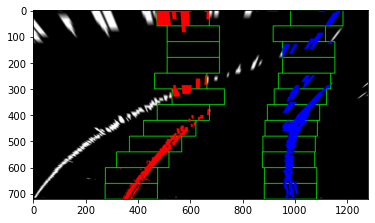

In [34]:
image = mpimg.imread('Frame_by_frame_challenge/frame1.jpg')
#image = mpimg.imread('test_images/test6.jpg')
undist = pipeline_v2(image)
plt.imshow(undist, cmap='gray')

In [599]:
path = 'test_images'
images_list = os.listdir(path)

for frame in range(500,580): 
    if not test_image_name == '.DS_Store':
        test_image = mpimg.imread('Frame_by_frame/frame' + str(frame) + '.jpg')
        img_res = pipeline_v2(test_image)
        write_name = 'res_frame'+str(frame)+'.jpg'
        #plt.savefig('foo.png')
        cv2.imwrite('test_images_results_v2/Frame_by_frame/'+write_name, img_res)

In [181]:
path = 'test_images'
images_list = os.listdir(path)

for test_image_name in images_list: 
    if not test_image_name == '.DS_Store':
        test_image = mpimg.imread('test_images/' + test_image_name)
        print(test_image_name)
        img_res = pipeline_v2(test_image)
        write_name = 'res_'+test_image_name
        plt.savefig('foo.png')
        cv2.imwrite('test_images_results_v2/Lane_final/'+write_name, img_res)

test6.jpg
(720, 1280, 3)
test5.jpg
(720, 1280, 3)
test4.jpg
(720, 1280, 3)
test1.jpg
(720, 1280, 3)
test3.jpg
(720, 1280, 3)
test2.jpg
(720, 1280, 3)
straight_lines2.jpg
(720, 1280, 3)
straight_lines1.jpg
(720, 1280, 3)


<Figure size 432x288 with 0 Axes>